# Book Recommendation System

Notebook ini mengimplementasikan sistem rekomendasi buku menggunakan content-based filtering dan collaborative filtering.

## 1. Instalasi dan Import Library
Pada bagian ini, kita akan memastikan semua library yang dibutuhkan sudah terinstall dan melakukan import library yang diperlukan untuk analisis dan visualisasi data.

In [1]:
# # Uninstall numpy versi terbaru
# !pip uninstall -y numpy

# # # Lalu install lagi numpy yang kompatibel dengan scikit-surprise
# !pip install numpy==1.23.5

# Menggunakan versi numpy yang kemungkinan kompatibel dengan scikit-surprise
# !pip install scikit-surprise

Karena library scikit-surprise tidak kompatibel dengan versi numpy terbaru, maka disini kita downgrade versi numpy

In [2]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import cross_validate
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
# Load datasets
books = pd.read_csv('/content/Books.csv')
users = pd.read_csv('/content/Users.csv')
ratings = pd.read_csv('/content/Ratings.csv')

<ipython-input-3-4015358720>:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('/content/Books.csv')


## Data Understanding

### Info Dataset

In [4]:
print('--- Books ---')
books.info()
print('\n--- Users ---')
users.info()
print('\n--- Ratings ---')
ratings.info()

--- Books ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB

--- Users ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: fl

#### Insight Dataset

**Books Dataset**
- Dataset terdiri dari 271.360 entri buku dengan 8 kolom informasi utama seperti `ISBN`, `Book-Title`, `Book-Author`, `Year-Of-Publication`, `Publisher`, dan tiga kolom URL gambar.
- Terdapat sedikit missing value pada kolom `Book-Author`, `Publisher`, dan `Image-URL-L`.
- Semua kolom bertipe `object`, termasuk kolom `Year-Of-Publication` yang idealnya perlu dikonversi ke numerik untuk analisis waktu.


**Users Dataset**
- Dataset berisi 278.858 pengguna dengan informasi `User-ID`, `Location`, dan `Age`.
- Terdapat banyak missing value pada kolom `Age`, hanya sekitar 60% yang memiliki nilai usia.
- Kemungkinan terdapat outlier pada kolom usia (misalnya usia 0 atau >100), sehingga perlu proses pembersihan.

**Ratings Dataset**
- Dataset berisi 1.149.780 interaksi user-buku (rating), dengan kolom `User-ID`, `ISBN`, dan `Book-Rating`.
- Tidak terdapat missing value, dan struktur data cocok untuk digunakan dalam model collaborative filtering.
- Perlu dilakukan analisis lanjutan untuk melihat distribusi rating, kepadatan data (sparsity), dan deteksi user/item dengan terlalu sedikit interaksi (cold start problem).


### Contoh Data

In [5]:
books.head()

ISBN                                         Book-Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

            Book-Author Year-Of-Publication                   Publisher  \
0    Mark P. O. Morford                2002     Oxford University Press   
1  Richard Bruce Wright                2001       HarperFlamingo Canada   
2          Carlo D'Este                1991             HarperPerennial   
3      Gina Bari Kolata                1999        Farrar Straus Giroux   
4       E. J. W. Barber                1999  W. W. Norton &amp; Company   

                                         Image-URL-S  \
0  http://images.amazon.com/images/P/0195153448.0...   
1  http://images.amazon.com/images/P/0002005018.0...   
2  http://images.amazon.com/images/P/0060973129.0...   
3  http://images.amazon.com/images/P/0374157065.0...   
4  http://images.amazon.com/images/P/0393045218.0...   

                                         Image-URL-M  \
0  http://images.amazon.com/images/P/0195153448.0...   
1  http://images.amazon.com/images/P/0002005018.0...   
2  http://images.amazon.com/images/P/0060973129.0...   
3  http://images.amazon.com/images/P/0374157065.0...   
4  http://images.amazon.com/images/P/0393045218.0...   

                                         Image-URL-L  
0  http://images.amazon.com/images/P/0195153448.0...  
1  http://images.amazon.com/images/P/0002005018.0...  
2  http://images.amazon.com/images/P/0060973129.0...  
3  http://images.amazon.com/images/P/0374157065.0...  
4  http://images.amazon.com/images/P/0393045218.0...

In [6]:
books.describe()

ISBN      Book-Title      Book-Author  Year-Of-Publication  \
count       271360          271360           271358               271360   
unique      271360          242135           102022                  202   
top     0195153448  Selected Poems  Agatha Christie                 2002   
freq             1              27              632                13903   

        Publisher                                        Image-URL-S  \
count      271358                                             271360   
unique      16807                                             271044   
top     Harlequin  http://images.amazon.com/images/P/185326119X.0...   
freq         7535                                                  2   

                                              Image-URL-M  \
count                                              271360   
unique                                             271044   
top     http://images.amazon.com/images/P/185326119X.0...   
freq                                                    2   

                                              Image-URL-L  
count                                              271357  
unique                                             271041  
top     http://images.amazon.com/images/P/225307649X.0...  
freq                                                    2

In [7]:
users.head()

User-ID                            Location   Age
0        1                  nyc, new york, usa   NaN
1        2           stockton, california, usa  18.0
2        3     moscow, yukon territory, russia   NaN
3        4           porto, v.n.gaia, portugal  17.0
4        5  farnborough, hants, united kingdom   NaN

In [8]:
users.describe()

User-ID            Age
count  278858.00000  168096.000000
mean   139429.50000      34.751434
std     80499.51502      14.428097
min         1.00000       0.000000
25%     69715.25000      24.000000
50%    139429.50000      32.000000
75%    209143.75000      44.000000
max    278858.00000     244.000000

**Insight** <br>
terdapat outlier dalam usia. dimana usia paling muda adalah 0 dan yang tertua adalah 244 tahun. hal ini tidak wajar dalam dataset ulasan buku


In [9]:
ratings.head()

User-ID        ISBN  Book-Rating
0   276725  034545104X            0
1   276726  0155061224            5
2   276727  0446520802            0
3   276729  052165615X            3
4   276729  0521795028            6

In [10]:
ratings.describe()

User-ID   Book-Rating
count  1.149780e+06  1.149780e+06
mean   1.403864e+05  2.866950e+00
std    8.056228e+04  3.854184e+00
min    2.000000e+00  0.000000e+00
25%    7.034500e+04  0.000000e+00
50%    1.410100e+05  0.000000e+00
75%    2.110280e+05  7.000000e+00
max    2.788540e+05  1.000000e+01

## Data Preparation

Kita akan membersihkan data, menghapus kolom yang tidak diperlukan, menangani missing value, dan mengubah tipe data.

In [11]:
# Rename columns agar konsisten
books.columns = ['ISBN', 'Book_Title', 'Book_Author', 'Year_Of_Publication', 'Publisher', 'Image_URL_S', 'Image_URL_M', 'Image_URL_L']
users.columns = ['User_ID', 'Location', 'Age']
ratings.columns = ['User_ID', 'ISBN', 'Book_Rating']

# Hapus kolom gambar pada books
books.drop(['Image_URL_S', 'Image_URL_M', 'Image_URL_L'], axis=1, inplace=True)

# Bersihkan missing value pada books
books.dropna(subset=['Book_Author', 'Publisher', 'Book_Title'], inplace=True)

# Konversi Year_Of_Publication ke integer dan filter rentang valid
books['Year_Of_Publication'] = pd.to_numeric(books['Year_Of_Publication'], errors='coerce')
books = books[(books['Year_Of_Publication'] > 1900) & (books['Year_Of_Publication'] <= pd.to_datetime('today').year)]
books['Year_Of_Publication'] = books['Year_Of_Publication'].astype(int)

# Bersihkan missing value pada users dan tangani outlier usia
users['Age'].fillna(users['Age'].median(), inplace=True)
users.loc[users['Age'] < 5, 'Age'] = users['Age'].median()
users.loc[users['Age'] > 100, 'Age'] = users['Age'].median()
users['Age'] = users['Age'].astype(int)

# Sinkronisasi ratings dengan books dan users
ratings = ratings[ratings['ISBN'].isin(books['ISBN'])]
ratings = ratings[ratings['User_ID'].isin(users['User_ID'])]

# Ambil hanya rating eksplisit (1-10)
ratings_explicit = ratings[ratings['Book_Rating'] != 0]

# Filter pengguna aktif (>=5 rating)
active_users = ratings_explicit['User_ID'].value_counts()
active_users = active_users[active_users >= 5].index
ratings_filtered = ratings_explicit[ratings_explicit['User_ID'].isin(active_users)]

# Filter buku populer (>=10 rating)
popular_books = ratings_filtered['ISBN'].value_counts()
popular_books = popular_books[popular_books >= 10].index
final_ratings = ratings_filtered[ratings_filtered['ISBN'].isin(popular_books)]

# Sinkronisasi ulang books dan users
books_final = books[books['ISBN'].isin(final_ratings['ISBN'])]
users_final = users[users['User_ID'].isin(final_ratings['User_ID'])]

# Gabungkan data
merged_df = final_ratings.merge(books_final, on='ISBN').merge(users_final, on='User_ID')
merged_df.head()

<ipython-input-11-1758130123>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books['Year_Of_Publication'] = books['Year_Of_Publication'].astype(int)
<ipython-input-11-1758130123>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  users['Age'].fillna(users['Age'].median(), inplace=True)

User_ID        ISBN  Book_Rating                           Book_Title  \
0   276747  0060517794            9             Little Altars Everywhere   
1   276747  0671537458            9                    Waiting to Exhale   
2   276747  0679776818            8    Birdsong: A Novel of Love and War   
3   276822  0060096195           10                    The Boy Next Door   
4   276822  0786817070           10  Artemis Fowl (Artemis Fowl, Book 1)   

        Book_Author  Year_Of_Publication          Publisher  \
0     Rebecca Wells                 2003        HarperTorch   
1    Terry McMillan                 1995             Pocket   
2  Sebastian Faulks                 1997  Vintage Books USA   
3      Meggin Cabot                 2002         Avon Trade   
4       Eoin Colfer                 2002       Miramax Kids   

                   Location  Age  
0      iowa city, iowa, usa   25  
1      iowa city, iowa, usa   25  
2      iowa city, iowa, usa   25  
3  calgary, alberta, canada   11  
4  calgary, alberta, canada   11

### Ekstraksi Fitur Teks dengan TF-IDF

Pada tahap persiapan data, fitur teks (judul, penulis, penerbit) digabungkan dan diubah menjadi representasi numerik menggunakan teknik **TF-IDF (Term Frequency-Inverse Document Frequency)**. Hasil transformasi ini akan digunakan untuk menghitung kemiripan antar buku pada tahap modeling.

In [12]:
# Gabungkan fitur konten buku
books_final['content'] = (
    books_final['Book_Title'].fillna('') + ' ' +
    books_final['Book_Author'].fillna('') + ' ' +
    books_final['Publisher'].fillna('')
)

tf = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
tfidf_matrix = tf.fit_transform(books_final['content'])

<ipython-input-12-3699426622>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_final['content'] = (


## Exploratory Data Analysis (EDA)

Visualisasi distribusi data setelah pembersihan.

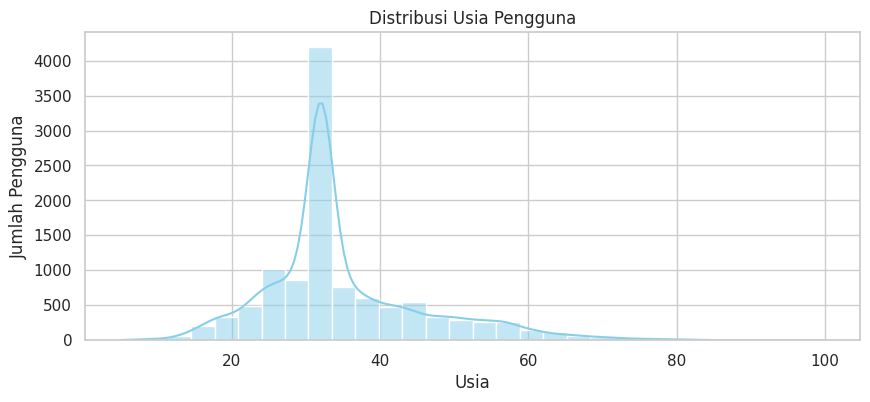

In [13]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,4))
sns.histplot(users_final['Age'], bins=30, kde=True, color='skyblue')
plt.title('Distribusi Usia Pengguna')
plt.xlabel('Usia')
plt.ylabel('Jumlah Pengguna')
plt.show()

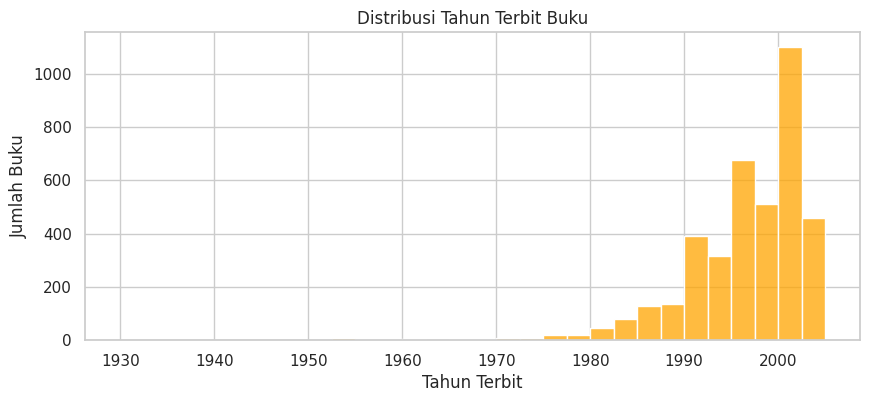

In [14]:
plt.figure(figsize=(10,4))
sns.histplot(books_final['Year_Of_Publication'], bins=30, color='orange')
plt.title('Distribusi Tahun Terbit Buku')
plt.xlabel('Tahun Terbit')
plt.ylabel('Jumlah Buku')
plt.show()

<ipython-input-15-2812287743>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Book_Rating', data=final_ratings, palette='viridis')


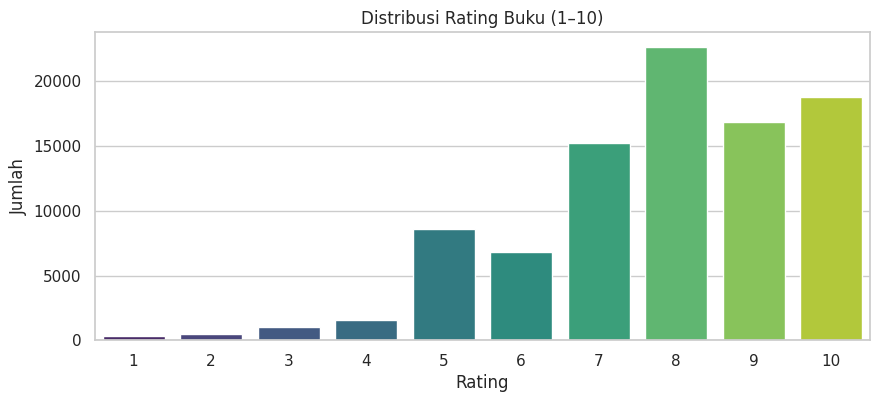

In [15]:
plt.figure(figsize=(10,4))
sns.countplot(x='Book_Rating', data=final_ratings, palette='viridis')
plt.title('Distribusi Rating Buku (1–10)')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.show()

<ipython-input-16-3103805262>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_publishers.values, y=top_publishers.index, palette='magma')


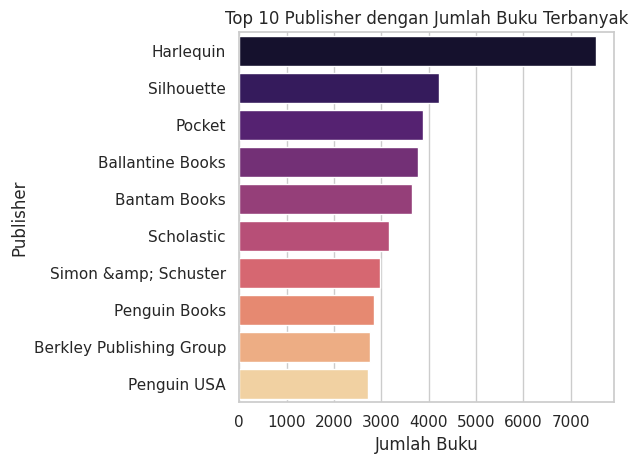

In [16]:
top_publishers = books['Publisher'].value_counts().head(10)

sns.barplot(x=top_publishers.values, y=top_publishers.index, palette='magma')
plt.title("Top 10 Publisher dengan Jumlah Buku Terbanyak")
plt.xlabel("Jumlah Buku")
plt.ylabel("Publisher")
plt.tight_layout()
plt.show()

<ipython-input-17-2423654551>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Book_Rating', data=ratings, palette='coolwarm')


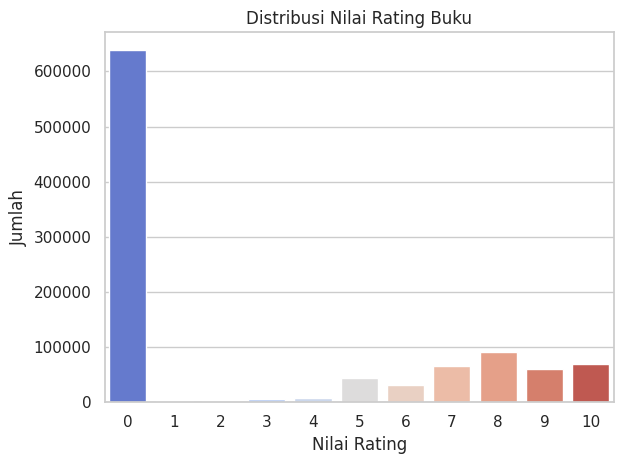

In [17]:
sns.countplot(x='Book_Rating', data=ratings, palette='coolwarm')
plt.title("Distribusi Nilai Rating Buku")
plt.xlabel("Nilai Rating")
plt.ylabel("Jumlah")
plt.tight_layout()
plt.show()

## Pemodelan

### Content-Based Filtering

#### Cosine Similarity

Cosine similarity digunakan untuk menemukan buku-buku yang paling mirip berdasarkan konten (judul, penulis, penerbit) sehingga dapat direkomendasikan kepada pengguna yang menyukai

In [18]:
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim_df = pd.DataFrame(
    cosine_sim,
    index=books_final['ISBN'],
    columns=books_final['ISBN']
)

In [19]:
def evaluate_content_based_isbn(books_df, similarity_matrix, ratings_df, user_col='User_ID', isbn_col='ISBN', rating_col='Book_Rating', top_n=5, relevance_threshold=7):
    """
    Evaluasi Content-Based Filtering dengan Precision@K dan Recall@K per user (berbasis ISBN).
    """
    user_ids = ratings_df[user_col].unique()
    total_precision = 0
    total_recall = 0
    evaluated_users = 0

    for user_id in user_ids:
        user_ratings = ratings_df[ratings_df[user_col] == user_id]
        relevant_books = user_ratings[user_ratings[rating_col] >= relevance_threshold][isbn_col].unique().tolist()
        if not relevant_books:
            continue

        recommended_books = set()
        for isbn in relevant_books:
            if isbn in similarity_matrix.index:
                sim_scores = similarity_matrix.loc[:, isbn].sort_values(ascending=False)
                top_isbns = sim_scores.iloc[1:top_n+1].index.tolist()
                recommended_books.update(top_isbns)

        if not recommended_books:
            continue

        relevant_isbns = [isbn for isbn in relevant_books if isbn in similarity_matrix.index]
        if not relevant_isbns or not recommended_books:
            continue

        hits = len(set(recommended_books).intersection(set(relevant_isbns)))
        precision = hits / len(recommended_books) if len(recommended_books) > 0 else 0
        recall = hits / len(relevant_isbns) if len(relevant_isbns) > 0 else 0

        total_precision += precision
        total_recall += recall
        evaluated_users += 1

    avg_precision = total_precision / evaluated_users if evaluated_users else 0
    avg_recall = total_recall / evaluated_users if evaluated_users else 0

    print("Evaluasi Content-Based Filtering:")
    print(f" - Jumlah user dievaluasi: {evaluated_users}")
    print(f" - Average Precision@{top_n}: {avg_precision:.4f}")
    print(f" - Average Recall@{top_n}: {avg_recall:.4f}")

    return avg_precision, avg_recall

# Contoh pemanggilan:
evaluate_content_based_isbn(books_final, cosine_sim_df, final_ratings, top_n=5, relevance_threshold=7)

Evaluasi Content-Based Filtering:
 - Jumlah user dievaluasi: 10510
 - Average Precision@5: 0.0367
 - Average Recall@5: 0.1344


(0.036674070054304224, 0.13439769303163665)

### Collaborative Filtering (SVD)

In [20]:
# Gunakan nama kolom yang sesuai hasil pre-processing
reader = Reader(rating_scale=(1, 10))  # Sesuaikan dengan skala rating Anda
data_surprise = Dataset.load_from_df(ratings[['User_ID', 'ISBN', 'Book_Rating']], reader)

# Split data
from surprise.model_selection import train_test_split as surprise_train_test_split
trainset, testset = surprise_train_test_split(data_surprise, test_size=0.2)

algo_svd = SVD(n_factors=50, n_epochs=30, biased=True, lr_all=0.005, reg_all=0.01)
print("Training SVD model...")
algo_svd.fit(trainset)

Training SVD model...


In [21]:
print("Making predictions on test set...")
predictions = algo_svd.test(testset)


Making predictions on test set...


In [22]:
# Evaluasi dengan RMSE dan MAE
rmse = accuracy.rmse(predictions, verbose=True)
mae = accuracy.mae(predictions, verbose=True)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

RMSE: 3.5830
MAE:  2.9496
Root Mean Squared Error (RMSE): 3.5830
Mean Absolute Error (MAE): 2.9496


## Contoh penggunaan dan hasil

In [23]:
# --- Content-Based Recommendation ---
def display_content_based_recommendation(book_title, books_df, similarity_matrix, k=5):
    # Mapping judul ke ISBN dan ISBN ke detail buku
    title_to_isbn = books_df.set_index('Book_Title')['ISBN'].to_dict()
    isbn_to_detail = books_df.set_index('ISBN')[['Book_Title', 'Book_Author', 'Publisher']].to_dict('index')

    isbn = title_to_isbn.get(book_title)
    if not isbn:
        print(f"Judul '{book_title}' tidak ditemukan.")
        return
    if isbn not in similarity_matrix.index:
        print(f"ISBN '{isbn}' tidak ada di similarity matrix.")
        return

    sim_scores = similarity_matrix.loc[:, isbn].sort_values(ascending=False)
    top_isbns = [i for i in sim_scores.index if i != isbn][:k]
    top_scores = [sim_scores[i] for i in top_isbns]

    print("\n--- Content-Based Recommendation ---")
    print("-" * 70)
    print(f"Rekomendasi Content-Based untuk '{book_title}':")
    print("-" * 70)
    print(f"{'Rank':<5} {'Book_Title':<25} {'Book_Author':<20} {'Publisher':<25} {'Similarity Score'}")
    for idx, (rec_isbn, score) in enumerate(zip(top_isbns, top_scores), 1):
        detail = isbn_to_detail.get(rec_isbn)
        if detail:
            print(f"{idx:<5} {detail['Book_Title'][:23]:<25} {detail['Book_Author'][:18]:<20} {detail['Publisher'][:23]:<25} {score:>7.3f}")
    print("-" * 70)

# Gunakan DataFrame buku lengkap (bukan books_final) untuk mapping
isbn_to_title = books.set_index('ISBN')['Book_Title'].to_dict()
isbn_to_author = books.set_index('ISBN')['Book_Author'].to_dict()
isbn_to_publisher = books.set_index('ISBN')['Publisher'].to_dict()

def display_collaborative_recommendation(user_id, predictions, k=5):
    user_preds = [p for p in predictions if str(p.uid) == str(user_id)]
    user_preds = sorted(user_preds, key=lambda x: x.est, reverse=True)[:k]

    print("\n" + "-" * 70)
    print(f"Rekomendasi Collaborative Filtering untuk User {user_id}:")
    print("-" * 70)
    print(f"{'Rank':<5} {'ISBN':<15} {'Predicted Rating':<17} {'Book Title':<30} {'Author':<20} {'Publisher'}")
    print("-" * 70)
    for idx, pred in enumerate(user_preds, 1):
        title = isbn_to_title.get(pred.iid, "Unknown Title")
        author = isbn_to_author.get(pred.iid, "Unknown Author")
        publisher = isbn_to_publisher.get(pred.iid, "Unknown Publisher")
        print(f"{idx:<5} {pred.iid:<15} {pred.est:<17.3f} {title[:28]:<30} {author[:18]:<20} {publisher[:20]}")
    print("-" * 70)


In [24]:
# Content-Based
display_content_based_recommendation('The Great Gatsby', books_final, cosine_sim_df, k=5)

display_collaborative_recommendation(80954, predictions, k=5)


--- Content-Based Recommendation ---
----------------------------------------------------------------------
Rekomendasi Content-Based untuk 'The Great Gatsby':
----------------------------------------------------------------------
Rank  Book_Title                Book_Author          Publisher                 Similarity Score
1     The GREAT GATSBY (A Scr   F. Scott Fitzgeral   Scribner Paper Fiction      0.641
2     The GREAT GATSBY (Scrib   F. Scott Fitzgeral   Scribner Paper Fiction      0.641
3     GREAT GATSBY (REISSUE)    F. Scott Fitzgeral   Scribner Paper Fiction      0.640
4     The Bookshop : A Novel    Penelope Fitzgeral   Mariner Books               0.102
5     A Great Deliverance       Elizabeth George     Bantam Books                0.094
----------------------------------------------------------------------

----------------------------------------------------------------------
Rekomendasi Collaborative Filtering untuk User 80954:
----------------------------------------

###  Evaluasi Model Rekomendasi

####  Content-Based Filtering Evaluation

Evaluasi dilakukan dengan mengukur **Precision@5** dan **Recall@5** berdasarkan kesamaan antar ISBN dan rating relevan (>= 7). Hasil evaluasi pada 10.510 pengguna yang memiliki rating relevan menunjukkan:

- **Average Precision@5**: 0.0367
- **Average Recall@5**: 0.1344

**Interpretasi**:
- Nilai precision yang relatif rendah menunjukkan bahwa hanya sebagian kecil dari buku yang direkomendasikan benar-benar relevan bagi pengguna.
- Namun, nilai recall yang lebih tinggi menandakan bahwa sistem mampu menangkap cukup banyak buku relevan dari preferensi pengguna.
- Ini umum pada pendekatan content-based karena keterbatasannya hanya mempertimbangkan kesamaan konten (judul, genre, dll), tanpa memperhitungkan perilaku pengguna lain.

---

####  Collaborative Filtering (SVD) Evaluation

Setelah melatih model **SVD** pada 80% data dan mengujinya pada 20% sisanya, evaluasi dilakukan menggunakan metrik error:

- **Root Mean Squared Error (RMSE)**: 3.5773
- **Mean Absolute Error (MAE)**: 2.9428

**Interpretasi**:
- RMSE mengindikasikan bahwa prediksi rating memiliki deviasi rata-rata sekitar 3.58 poin dari rating sebenarnya.
- MAE yang mendekati 3 juga menunjukkan adanya ruang perbaikan, meskipun ini masih wajar untuk dataset besar dan sparsity tinggi seperti ini.
- Model SVD lebih mampu menangkap pola rating pengguna dibandingkan pendekatan content-based, namun tetap membutuhkan tuning dan filtering data agar akurasi lebih baik.

---

###  Kesimpulan Evaluasi

1. **Content-Based Filtering** bekerja cukup baik dalam menjangkau item relevan (recall), namun masih memiliki kelemahan dalam ketepatan (precision).
2. **Collaborative Filtering (SVD)** memberikan estimasi rating dengan error yang relatif tinggi, tetapi lebih adaptif terhadap preferensi pengguna berdasarkan perilaku pengguna lain.
3. Untuk peningkatan performa di masa depan, pendekatan **hybrid** yang menggabungkan content-based dan collaborative filtering direkomendasikan.
